<a href="https://colab.research.google.com/github/krishnakaushik25/Tweets_classifier_NLP/blob/master/simpletransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpletransformers


In [ ]:
import os, re, string
import random

import numpy as np
import pandas as pd
import sklearn

import torch

from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
seed = 1337

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
# Zero pre-processing of training data
# I have tried doing some preprcessing/cleaning but the result 
# does not seem significant
train_data = pd.read_csv('/content/drive/My Drive/train.csv')
train_data = train_data[['text', 'target']]

Check default value of model and tweak

In [ ]:
# Using 'bert-large-uncased' here. For a list of other models, refer to 
# https://github.com/ThilinaRajapakse/simpletransformers/#current-pretrained-models 
bert_uncased = ClassificationModel('bert', 'bert-large-uncased') 

# Print out all the default arguments for reference
bert_uncased.args

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

ClassificationArgs(adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', custom_layer_parameters=[], custom_parameter_groups=[], train_custom_parameters_only=False, config={}, dataloader_num_workers=1, do_lower_case=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=2000, evaluate_during_training_verbose=False, fp16=True, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=4e-05, local_rank=-1, logging_steps=50, manual_seed=None, max_grad_norm=1.0, max_seq_length=128, multiprocessing_chunksize=500, n_gpu=1, no_cache=False, no_save=False, num_train_epochs=1, output_dir='outputs/', overwrite_output_dir=False, process_count=1, reprocess_input_data=True, save_best_model=True, save_eval_checkpoints=True

In [ ]:
# This is where we can tweak based on the default arguments above
custom_args = {'fp16': False, # not using mixed precision 
               'train_batch_size': 4, # default is 8
               'gradient_accumulation_steps': 2,
               'do_lower_case': True,
               'learning_rate': 1e-05, # using lower learning rate
               'overwrite_output_dir': True, # important for CV
               'num_train_epochs': 2} # default is 1

5-Fold CV

In [ ]:
n=5
kf = KFold(n_splits=n, random_state=seed, shuffle=True)
results = []

for train_index, val_index in kf.split(train_data):
    train_df = train_data.iloc[train_index]
    val_df = train_data.iloc[val_index]
    
    model = ClassificationModel('bert', 'bert-base-uncased', args=custom_args) 
    model.train_model(train_df)
    result, model_outputs, wrong_predictions = model.eval_model(val_df, acc=sklearn.metrics.accuracy_score)
    print(result['acc'])
    results.append(result['acc'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:275: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:748: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."



0.855548260013132


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


0.8214051214707814


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


0.8397898883782009


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


0.831143232588699


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


0.8521681997371879


In [ ]:
for i, result in enumerate(results, 1):
    print(f"Fold-{i}: {result}")
    
print(f"{n}-fold CV accuracy result: Mean: {np.mean(results)} Standard deviation:{np.std(results)}")

Fold-1: 0.855548260013132
Fold-2: 0.8214051214707814
Fold-3: 0.8397898883782009
Fold-4: 0.831143232588699
Fold-5: 0.8521681997371879
5-fold CV accuracy result: Mean: 0.8400109404376004 Standard deviation:0.012759849992864959


In [ ]:
model = ClassificationModel('bert', 'bert-base-uncased', args=custom_args) 
model.train_model(train_data)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Predict on test data

In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/test.csv')
predictions, raw_outputs = model.predict(test_data['text'])

sample_submission = pd.read_csv("/content/drive/My Drive/sample_submission (2).csv")
sample_submission["target"] = predictions
sample_submission.to_csv("submission.csv", index=False)

/content/submission.csv the result

BILSTM

In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [ ]:
tweet = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')
submission = pd.read_csv('/content/drive/My Drive/sample_submission (2).csv')

Text(0, 0.5, 'tweets')

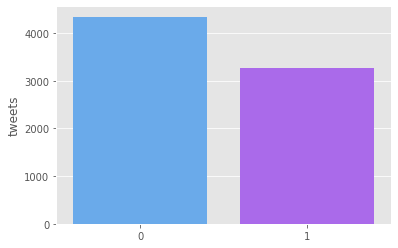

In [ ]:
#Checking the class distribution
x = tweet.target.value_counts()
sns.barplot(x.index, x, palette='cool')
plt.gca().set_ylabel('tweets')

In [ ]:
def create_corpus_df(tweet, target):
    corpus=[]
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
def create_corpus(target):
    corpus=[]
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Data cleaning

In [ ]:
df = pd.concat([tweet,test])
df.shape

(10876, 5)

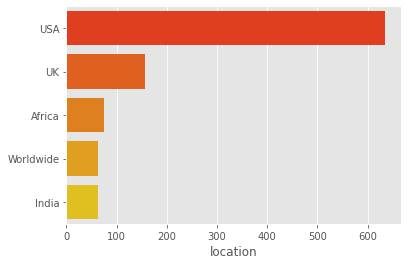

In [ ]:
#Renaming location names
df['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y = df['location'].value_counts()[:5].index, x = df['location'].value_counts()[:5],
            palette='autumn', orient='h')

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
# Applying the cleaning function to both test and training datasets
df['text'] = df['text'].apply(lambda x: clean_text(x))
# Let's take a look at the updated text
df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
#Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [ ]:
tweet_1 = tweet.text.values
test_1 = test.text.values
sentiments = tweet.target.values

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(tweet_1)
vocab_length = len(word_tokenizer.word_index) + 1

In [ ]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [ ]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [ ]:
import nltk
nltk.download('punkt')
longest_train = max(tweet_1, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(tweet_1), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    embed(test_1), 
    length_long_sentence,
    padding='post'
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/content/drive/My Drive/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences, 
    sentiments, 
    test_size=0.25
)

In [ ]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Train on 5709 samples, validate on 1904 samples
Epoch 1/7
5709/5709 [==============================] - 55s 10ms/step - loss: 0.6686 - accuracy: 0.6647 - val_loss: 0.5901 - val_accuracy: 0.7962

Epoch 00001: val_loss improved from inf to 0.59006, saving model to model.h5
Epoch 2/7
5709/5709 [==============================] - 52s 9ms/step - loss: 0.5250 - accuracy: 0.7567 - val_loss: 0.4615 - val_accuracy: 0.8109

Epoch 00002: val_loss improved from 0.59006 to 0.46153, saving model to model.h5
Epoch 3/7
5709/5709 [==============================] - 52s 9ms/step - loss: 0.4734 - accuracy: 0.7937 - val_loss: 0.4138 - val_accuracy: 0.8241

Epoch 00003: val_loss improved from 0.46153 to 0.41376, saving model to model.h5
Epoch 4/7
5709/5709 [==============================] - 52s 9ms/step - loss: 0.4368 - accuracy: 0.8143 - val_loss: 0.4081 - val_accuracy: 0.8199

Epoch 00004: val_loss improved from 0.41376 to 0.40811, saving model to model.h5
Epoch 5/7
5709/5709 [==============================

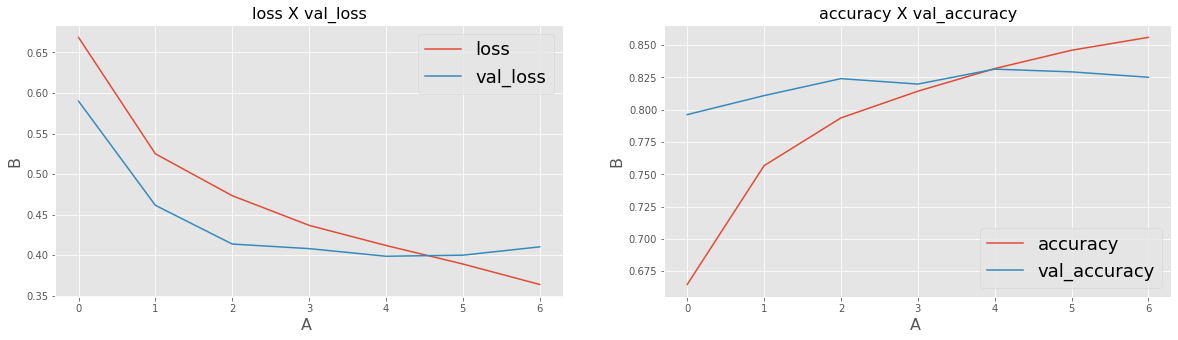

In [ ]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

1904/1904 [==============================] - 1s 765us/step
Loss: 0.41029396603087415
Accuracy: 0.8251050710678101


In [ ]:
preds = model.predict_classes(X_test)
metrics(preds, y_test)

F1-score:  0.7766599597585513
Precision:  0.6934131736526946
Recall:  0.8826219512195121
Acuracy:  0.8251050420168067
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1248
           1       0.69      0.88      0.78       656

    accuracy                           0.83      1904
   macro avg       0.81      0.84      0.82      1904
weighted avg       0.85      0.83      0.83      1904



In [ ]:
model.load_weights('model.h5')
preds = model.predict_classes(X_test)
metrics(preds, y_test)

F1-score:  0.7948881789137381
Precision:  0.7449101796407186
Recall:  0.852054794520548
Acuracy:  0.8314075630252101
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1174
           1       0.74      0.85      0.79       730

    accuracy                           0.83      1904
   macro avg       0.82      0.84      0.83      1904
weighted avg       0.84      0.83      0.83      1904



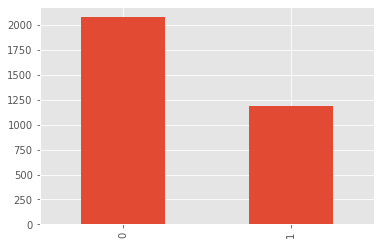

In [ ]:
submission.target = model.predict_classes(test_sentences)
submission.to_csv("submission.csv", index=False)
submission.target.value_counts().plot.bar();

/content/submission.csv the resultant csv 


Naive Bayes

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.validation import check_X_y, check_array

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/train.csv")
submit_df = pd.read_csv("/content/drive/My Drive/test.csv")

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Labels data
train_y = train_df['target']

In [ ]:
train_y.unique()

array([1, 0])

Create the vocabulary, the word count and prepare the train_X¶


In [ ]:
vocabulary = []
_ = [vocabulary.extend(x.split()) for i,x in enumerate(train_df['text'])]

In [ ]:
vocabulary = np.array(vocabulary)

In [ ]:
vocab = np.unique(vocabulary)

In [ ]:
len(vocab)

31924

In [ ]:
vectorizer = CountVectorizer(vocabulary=vocab)
word_counts = vectorizer.fit_transform(train_df.text.to_numpy()).toarray()

In [ ]:
train_x = pd.DataFrame(word_counts, columns=vocab).to_numpy()

Implementation of NaiveBayes

prior	P(y) -	Probability of any random selected message belonging to a class      
ik_word	P(Xi|y) -	Likelihood of each word, conditional on message class         
lk_message	P(x|y) -	Likelihood of an entire message belonging to a particular class             
normalize_term	P(x) -	Likelihood of an entire message across all possible classes

In [ ]:
class NaiveBayes():
    def __init__(self, alpha=1.0):
        self.prior = None
        self.word_counts = None
        self.lk_word = None
        self.alpha = alpha
        
    def fit(self, x, y):
        '''
        Fit the features and the labels
        Calculate prior, word_counts and lk_word
        '''
        x, y = check_X_y(x, y)
        n = x.shape[0]
        
        # calculate the prior - number of text belonging to a particular class (real or fake)
        x_per_class = np.array([x[y == c] for c in np.unique(y)])
        self.prior = np.array([len(x_class) / n for x_class in x_per_class])
        
        # calculate the likelihood for each word 'lk_word'
        self.word_counts = np.array([sub_arr.sum(axis=0) for sub_arr in x_per_class]) + self.alpha
        self.lk_word = self.word_counts / self.word_counts.sum(axis=1).reshape(-1, 1)
        
        return self
    
    def _get_class_numerators(self, x):
        '''
        Calculate for each class, the likelihood that an entire message conditional
        on the message belonging to a particular class (real or fake)
        '''
        n, m = x.shape[0], self.prior.shape[0]
        
        class_numerators = np.zeros(shape=(n, m))
        for i, word in enumerate(x):
            word_exists = word.astype(bool)
            lk_words_present = self.lk_word[:, word_exists] ** word[word_exists]
            lk_message = (lk_words_present).prod(axis=1)
            class_numerators[i] = lk_message * self.prior
        
        return class_numerators
    
    def _normalized_conditional_probs(self, class_numerators):
        '''
        Conditional probabilities = class_numerators / normalize_term
        '''
        # normalize term is the likelihood of an entire message (addition of all words in a row)
        normalize_term = class_numerators.sum(axis=1).reshape(-1,1)
        conditional_probs = class_numerators / normalize_term
        assert(conditional_probs.sum(axis=1) - 1 < 0.001).all(), 'rows should sum to 1'
        
        return conditional_probs
    
    def predict_proba(self, x):
        '''
        Return the probabilities for each class (fake or real)
        '''
        class_numerators = self._get_class_numerators(x)
        conditional_probs = self._normalized_conditional_probs(class_numerators)
        
        return conditional_probs
    

    def predict(self, x):
        '''
        Return the answer with the highest probability (argmax)
        '''
        return self.predict_proba(x).argmax(axis=1)

In [ ]:
NaiveBayes().fit(train_x,train_y).predict(train_x)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
submit_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# word counts for submit using vectorizer from sklearn
word_counts_submit = vectorizer.fit_transform(submit_df.text.to_numpy()).toarray()

In [ ]:
submit_x = pd.DataFrame(word_counts_submit, columns=vocab).to_numpy()

In [ ]:
# use naive bayes to predict the submission
result = NaiveBayes().fit(train_x,train_y).predict(submit_x)

In [ ]:
final_result = list(map(list, zip(submit_df.id.to_numpy(), result)))

In [ ]:
final_df = pd.DataFrame(final_result, columns=['id', 'target'])

In [ ]:
final_df.to_csv("submissionnb.csv",index=False)

/content/submissionnb.csv the end result csv file